In [1]:
import torch, torchvision
import detectron2
import time
import os, json, cv2, random
import numpy as np
import detectron2.data.transforms as T
import matplotlib.pyplot as plt

from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.data import MetadataCatalog
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data.detection_utils import read_image
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.structures import ImageList, Instances, BitMasks

from sparseinst import add_sparse_inst_config

@torch.jit.script
def normalizer(x, mean, std): return (x - mean) / std

def cv2_imshow(im):
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

device = torch.device('cuda:0')
dtype = torch.float32

cfg = get_cfg()
model_config = "/home/lujia/test/SparseInst-main/configs/sparse_inst_mb_giam_person.yaml"
add_sparse_inst_config(cfg)
cfg.merge_from_file(model_config)
cfg.freeze()

In [2]:
model = build_model(cfg)
model.eval()
metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0])
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)
# aug = T.ResizeShortestEdge([cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST)
# print(cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MAX_SIZE_TEST)

pixel_mean = torch.Tensor([123.675, 116.280, 103.530]).to(device).view(3, 1, 1)
pixel_std = torch.Tensor([58.395, 57.120, 57.375]).to(device).view(3, 1, 1)

path = '/home/lujia/test/SparseInst-main/datasets/coco/val2017/000000000632.jpg'
path = '/home/lujia/test/SparseInst-main/datasets/coco/val2017/000000000785.jpg'
# path = '/home/lujia/test/SparseInst-main/datasets/coco/val2017/000000001000.jpg'
# path = '/home/lujia/test/SparseInst-main/datasets/coco/val2017/000000000885.jpg'
original_image = read_image(path, format="RGB")
print(original_image.shape)
image = cv2.resize(original_image, (320, 320))
height, width = image.shape[:2]
# image = aug.get_transform(original_image).apply_image(original_image)

# image = np.array(image.cpu())
image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1)).to(device)
# image = torch.as_tensor(image.transpose(2, 0, 1)).to(device)
image = normalizer(image, pixel_mean, pixel_std)
image = image.repeat(2,1,1,1)
print(image.shape)

t0 = time.time()
predictions = model(image)
t1 = time.time()
print(predictions[0].shape)
print(predictions[1].shape)
print(predictions[2].shape)
print("pytorch:%s" % (t1-t0))

(425, 640, 3)
torch.Size([2, 3, 320, 320])
torch.Size([2, 100])
torch.Size([2, 100])
torch.Size([2, 100, 320, 320])
pytorch:0.07719230651855469


(640, 800, 3)


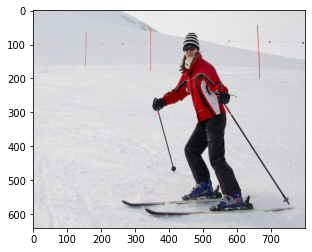

In [3]:
print(original_image.shape)
plt.imshow(original_image)

torch.Size([3, 640, 800]) torch.Size([100]) torch.Size([100]) torch.Size([100, 640, 800])


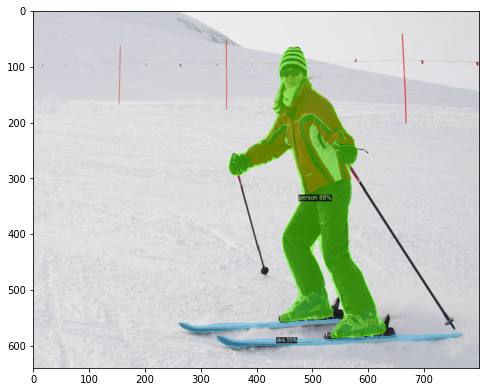

In [4]:
plt.rcParams['figure.figsize'] = (8,16)
cpu_device = torch.device("cpu")
visualizer = Visualizer(original_image, metadata, instance_mode=ColorMode.IMAGE, scale=1)
for i,(cur_image, scores, pred_classes, pred_masks) in enumerate(zip(image, predictions[0], predictions[1], predictions[2])):
    print(cur_image.shape, scores.shape, pred_classes.shape, pred_masks.shape)
    shape = cur_image[1:]
    result = Instances(shape)
    result.pred_masks = pred_masks
    result.scores = scores
    result.pred_classes = pred_classes
    result = result[result.scores > 0.5].to(cpu_device)
    vis_output = visualizer.draw_instance_predictions(predictions=result)
    cv2_imshow(vis_output.get_image()[:, :, ::-1])

(640, 800)
(640, 800, 3)
(640, 800, 3)
(640, 800, 3)


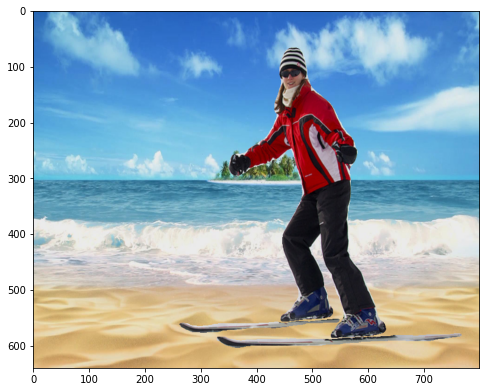

In [5]:
pred_masks_ = pred_masks[scores > 0.5].to(cpu_device)
mask = (pred_masks_.any(dim=0) > 0).numpy()
print(mask.shape)
print(original_image.shape)

bg_path = '/home/lujia/SparseInst/pic/bg.jpg' 
bg_pic = read_image(bg_path, format="RGB")
bg_pic = cv2.resize(bg_pic, (800, 640))
print(bg_pic.shape)
show_pic = bg_pic
show_pic[mask] = original_image[mask]
print(show_pic.shape)
plt.imshow(show_pic)

In [3]:
output_names = ["scores", "pred_classes", "pred_masks"]
input_names = ["images"]
dynamic_axes = {
    "images": {0: "batch_size", 2: "height", 3: "width"},
    "scores": {0: "batch_size"},
    "pred_classes": {0: "batch_size"},
    "pred_masks": {0: "batch_size"}, 2: "height", 3: "width"}
dynamic_axes = {
    "images": {0: "batch_size"}}
onnx_f = 'model_mb_person_b2.onnx'
# new_input = [{"batched_inputs": [inputs]}]
torch.onnx.export(
        model,
        image,
        onnx_f,
        input_names=input_names,
        output_names=output_names,
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        verbose=True,
        dynamic_axes=None,
    )

/home/lujia/.conda/envs/dete2/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/home/lujia/test/SparseInst-main/sparseinst/sparseinst.py:134: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  for _, (scores_per_image, mask_pred_per_image, image) in enumerate(zip(
/home/lujia/test/SparseInst-main/sparseinst/sparseinst.py:147: TracerWarnin

graph(%images : Float(2, 3, 320, 320, strides=[307200, 102400, 320, 1], requires_grad=0, device=cuda:0),
      %backbone.features.0.0.weight : Float(32, 3, 3, 3, strides=[27, 9, 3, 1], requires_grad=1, device=cuda:0),
      %backbone.features.1.conv.0.0.weight : Float(32, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=1, device=cuda:0),
      %backbone.features.1.conv.1.weight : Float(16, 32, 1, 1, strides=[32, 1, 1, 1], requires_grad=1, device=cuda:0),
      %backbone.features.2.conv.0.0.weight : Float(96, 16, 1, 1, strides=[16, 1, 1, 1], requires_grad=1, device=cuda:0),
      %backbone.features.2.conv.1.0.weight : Float(96, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=1, device=cuda:0),
      %backbone.features.2.conv.2.weight : Float(24, 96, 1, 1, strides=[96, 1, 1, 1], requires_grad=1, device=cuda:0),
      %backbone.features.3.conv.0.0.weight : Float(144, 24, 1, 1, strides=[24, 1, 1, 1], requires_grad=1, device=cuda:0),
      %backbone.features.3.conv.1.0.weight : Float(144, 1, 3, 3

In [9]:
import onnx
import onnxruntime as ort
import numpy as np

model = onnx.load("/home/lujia/test/SparseInst-main/model_mb_sim.onnx")
onnx.checker.check_model(model)
# print(onnx.helper.printable_graph(model.graph))

providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] # 30 ms
# providers = ['CPUExecutionProvider'] # 470ms

ort_session = ort.InferenceSession('/home/lujia/test/SparseInst-main/model_mb_sim.onnx', providers=providers)
input_onnx = image.cpu().numpy().astype(np.float32)
t_list = []
for i in range(10):
    t0 = time.time()
    outputs = ort_session.run(None, {'images': input_onnx})
    t1 = time.time()
    t_list.append(np.round(t1-t0, 4)*1000)
print(t_list)

[816.6, 27.5, 29.7, 32.5, 28.6, 27.2, 27.3, 27.2, 27.7, 27.400000000000002]


torch.Size([3, 640, 800]) (100,) (100,) (100, 640, 800)


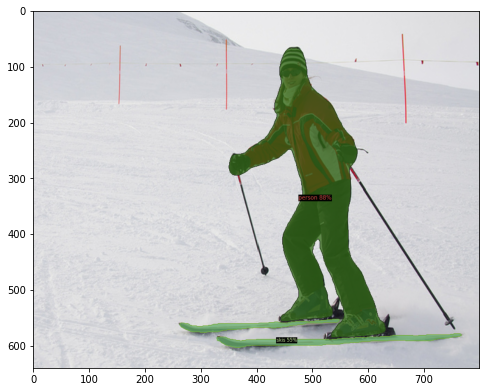

In [8]:
for i,(cur_image, scores, pred_classes, pred_masks) in enumerate(zip(image, outputs[0], outputs[1], outputs[2])):
    print(cur_image.shape, scores.shape, pred_classes.shape, pred_masks.shape)
    shape = cur_image[1:]
    result = Instances(shape)
    result.pred_masks = pred_masks
    result.scores = scores
    result.pred_classes = pred_classes
    result = result[result.scores > 0.5].to(cpu_device)
    vis_output = visualizer.draw_instance_predictions(predictions=result)
    cv2_imshow(vis_output.get_image()[:, :, ::-1])

(640, 800)
(640, 800, 3)
(640, 800, 3)
(640, 800, 3)


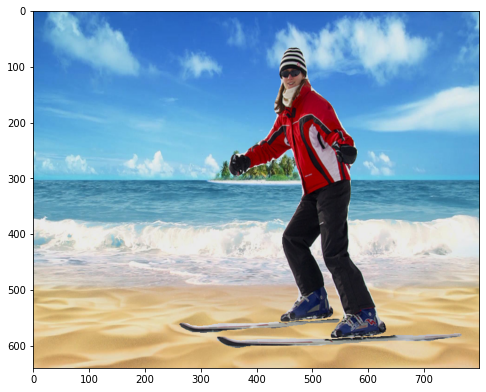

In [15]:
pred_masks_ = pred_masks[scores > 0.5]
mask = (pred_masks_.any(axis=0) > 0)
print(mask.shape)
print(original_image.shape)

bg_path = '/home/lujia/SparseInst/pic/bg.jpg' 
bg_pic = read_image(bg_path, format="RGB")
bg_pic = cv2.resize(bg_pic, (800, 640))
print(bg_pic.shape)
show_pic = bg_pic
show_pic[mask] = original_image[mask]
print(show_pic.shape)
plt.imshow(show_pic)

In [5]:
import onnx
import onnxoptimizer
from onnxsim import simplify

onnx_model = onnx.load("/home/lujia/test/SparseInst-main/model_mb_person_b2.onnx")  # load onnx model

new_model = onnxoptimizer.optimize(onnx_model)
onnx.save(new_model, "model_mb_person_b2_opt.onnx")

model_simp, check = simplify(new_model, input_shapes={'images': [2, 3, 320, 320]})
assert check, "Simplified ONNX model could not be validated"
onnx.save(model_simp, "model_mb_person_b2_sim.onnx")